In [1]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np

In [2]:
test_image_paths = {'buildings': [],
           'forest': [],
           'glacier': [],
           'mountain': [],
           'sea': [],
           'street': []
          }
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [3]:
DATASET_PATH = "../dataset"

In [4]:
def go_though_database(database_path):
    i = 0
    for path, subdirs, files in os.walk(database_path):
        for file in files:
            correct_system_path = os.path.join('seg_test', 'seg_test') 
            if correct_system_path in path:
                file_path = os.path.join(path, file)
                for category in categories:
                    if category in file_path:
                        test_image_paths[category].append(file_path)

In [5]:
go_though_database(DATASET_PATH)

In [6]:
def save_edited_images(image_paths, category, set_type):
    directory = f"../dataset/edited/{set_type}/{category}"
    for index, image_path in enumerate(image_paths):
        edited_image_name = image_path.split('\\')[-1].split('.')[0] + '_edited.jpg'
        edited_image_path = os.path.join(directory, edited_image_name)
        # (input_image_path, output_image_path)
        image_paths[index] = (edited_image_path, image_path)

In [7]:
CHOOSEN_CATEGORY="buildings"

In [8]:
save_edited_images(test_image_paths[CHOOSEN_CATEGORY], CHOOSEN_CATEGORY, "test")

In [9]:
def load(input_image_path, output_image_path):
    input_image = tf.io.read_file(input_image_path)
    input_image = tf.io.decode_jpeg(input_image)
    input_image = tf.cast(input_image, tf.float32)
    output_image = tf.io.read_file(output_image_path)
    output_image = tf.io.decode_jpeg(output_image)
    output_image = tf.cast(output_image, tf.float32)
    return input_image, output_image

In [10]:
def normalize_images(input_image, output_image) :
    input_image = (input_image / (MAX_PIXEL_COLOR_VALUE / 2)) - 1 
    output_image = (output_image / (MAX_PIXEL_COLOR_VALUE / 2)) - 1  
    return input_image, output_image

In [11]:
def resize_images(input_image, output_image, height, width): 
    input_image = tf.image.resize(input_image, [height, width])
    output_image = tf.image.resize(output_image, [height, width])
    return input_image, output_image

In [12]:
def crop_images(input_image, output_image, height, width):
    stacked_image = tf.stack([input_image, output_image], axis=0)
    cropped_image = tf.image.random_crop(
    stacked_image, size=[2, height, width, 3])
    return cropped_image[0], cropped_image[1]

In [13]:
def make_image_set(image_paths) :
    images = []
    for image_path_pair in image_paths[CHOOSEN_CATEGORY]:
        input_image_path, output_image_path = image_path_pair
        input_image_path = input_image_path.replace("\\", "/")
        output_image_path = output_image_path.replace("\\", "/")
        input_image, output_image = load(input_image_path, output_image_path)
        input_image, output_image = resize_images(input_image, output_image, IMAGE_HEIGHT, IMAGE_WIDTH)
        images.append(normalize_images(input_image, output_image))
    return images

In [14]:
CHOOSEN_CATEGORY="buildings"

In [15]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
MAX_PIXEL_COLOR_VALUE = 255.0

In [16]:
test_images = make_image_set(test_image_paths)

In [17]:
input_image, output_image = test_images[0]

In [18]:
%run Generator.ipynb

Model: "gen"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3392        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131712      ['sequential[0][0]']             
                                                                                                

In [19]:
generator = Generator(input_image.shape)

In [20]:
%run Discriminator.ipynb

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 target_image (InputLayer)      [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_14 (Concatenate)   (None, 256, 256, 6)  0           ['input_image[0][0]',            
                                                                  'target_image[0][0]']       

In [21]:
discriminator = Discriminator(input_image.shape)

In [22]:
from enum import Enum

class BLACKOUT_AREA_TYPE(Enum):
    FRAME = 1
    HORIZONTAL = 2

    def __str__(self):
        return '%s' % self.value

In [23]:
# this value has to be the same as the one in main
blackout_area_type = BLACKOUT_AREA_TYPE.HORIZONTAL

In [26]:
checkpoint_dir = '../training_checkpoints_' + str(blackout_area_type)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator.optimizer,
                                 discriminator_optimizer=discriminator.optimizer,
                                 generator=generator.model,
                                 discriminator=discriminator.model)

In [27]:
def display_images(generator_model, input_image, output_image):
    generated_image = generator_model(input_image[tf.newaxis, ...], training=True)
    fig = plt.figure(figsize=(10, 7)) 
    rows = 1
    columns = 3
    fig.add_subplot(rows, columns, 1) 
    plt.imshow(input_image *  0.5 + 0.5)
    plt.title("Input") 
    fig.add_subplot(rows, columns, 2) 
    plt.imshow(output_image *  0.5 + 0.5)
    plt.title("Output")  
    fig.add_subplot(rows, columns, 3) 
    plt.imshow(generated_image[0] *  0.5 + 0.5)    
    plt.title("Generated") 

In [28]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [29]:
import random

In [30]:
NUMBER_OF_TEST_IMAGES = 20

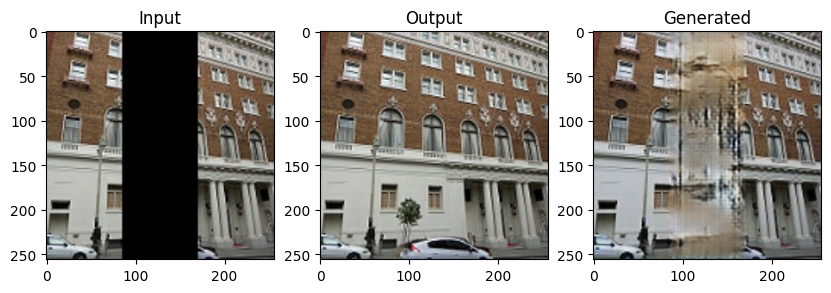

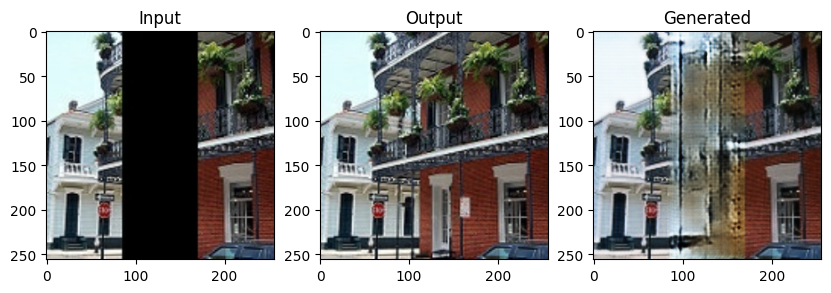

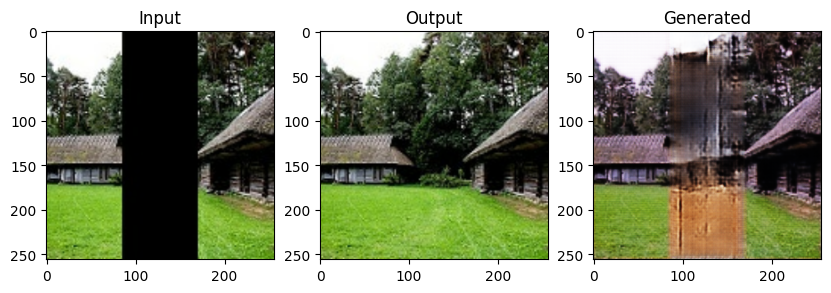

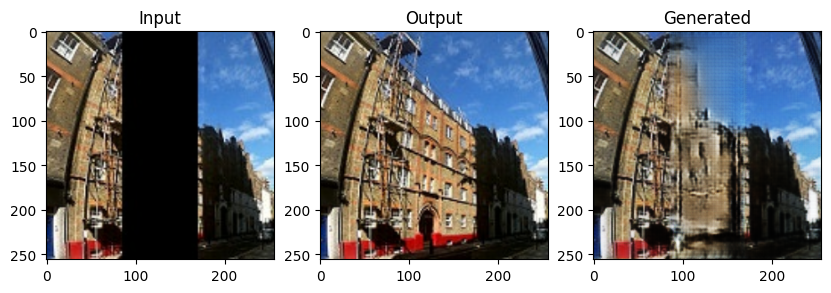

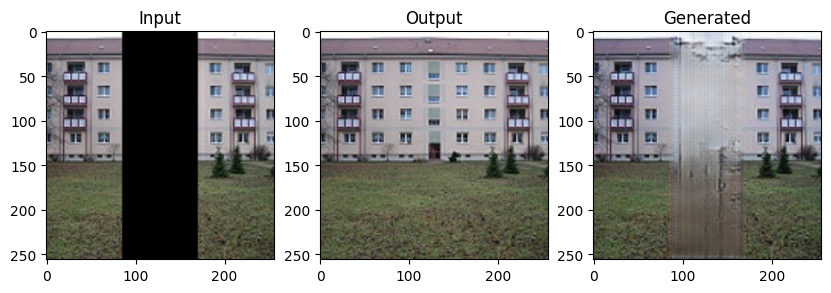

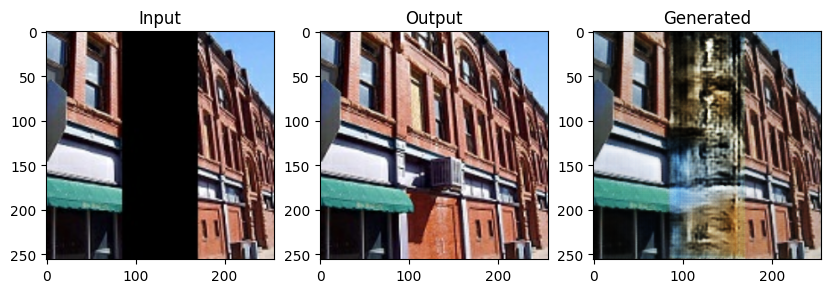

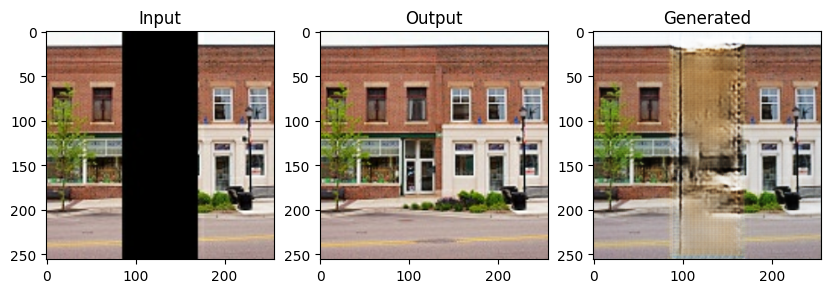

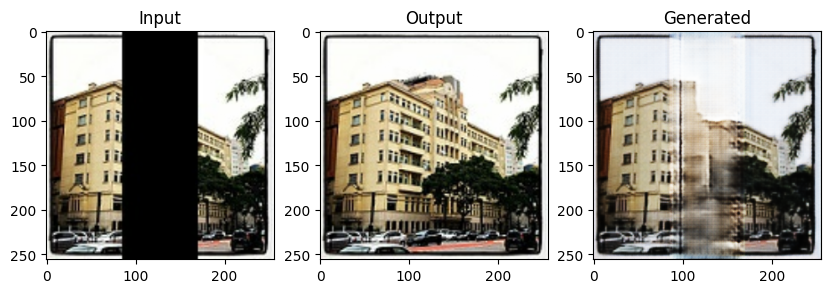

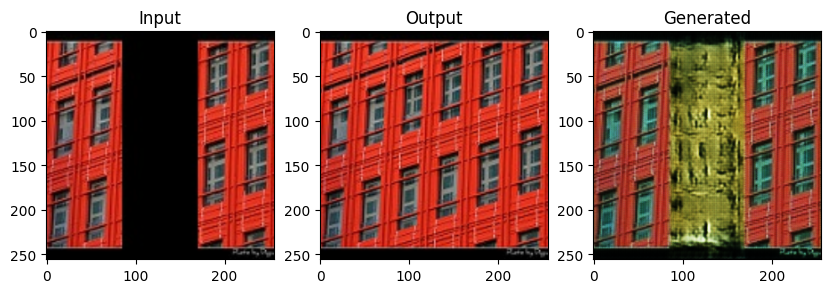

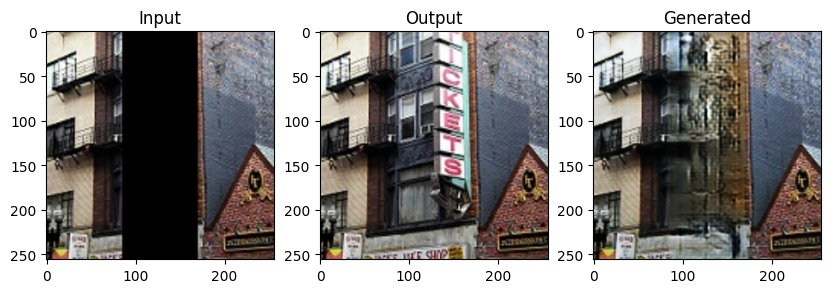

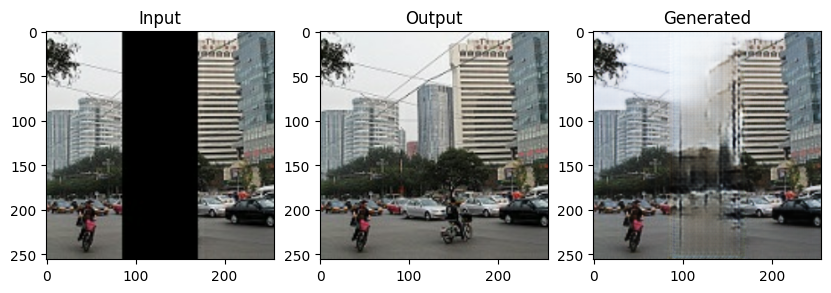

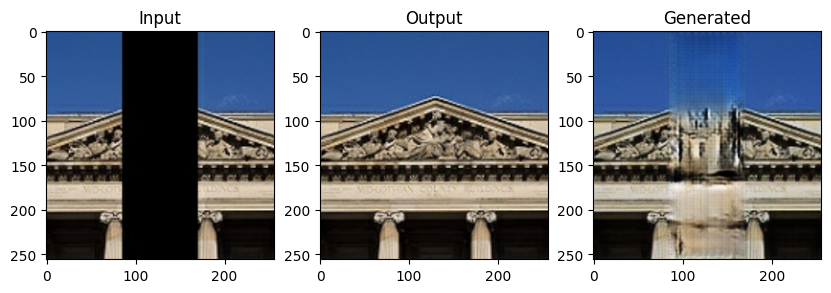

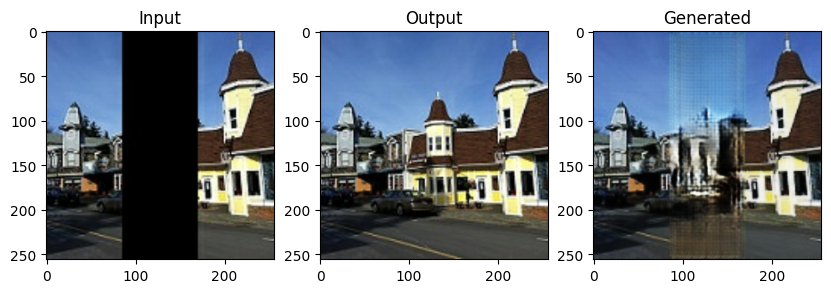

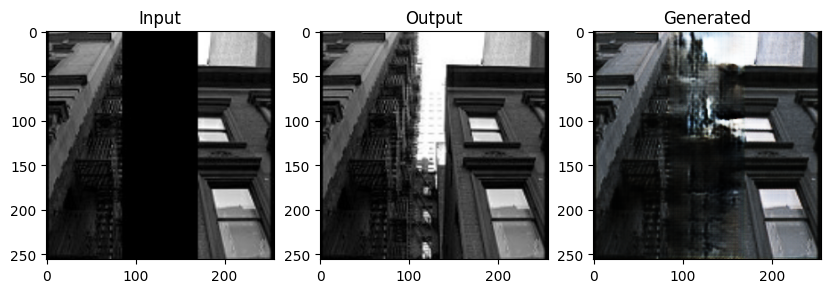

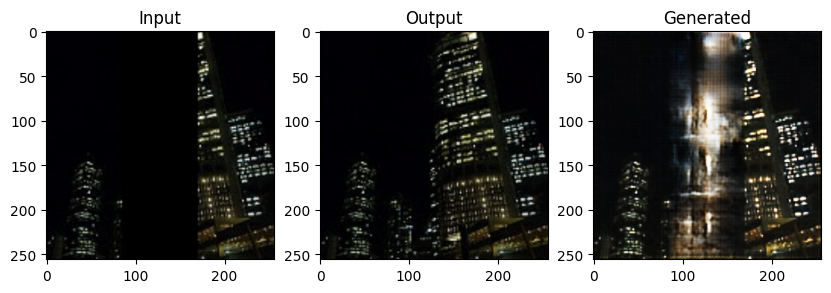

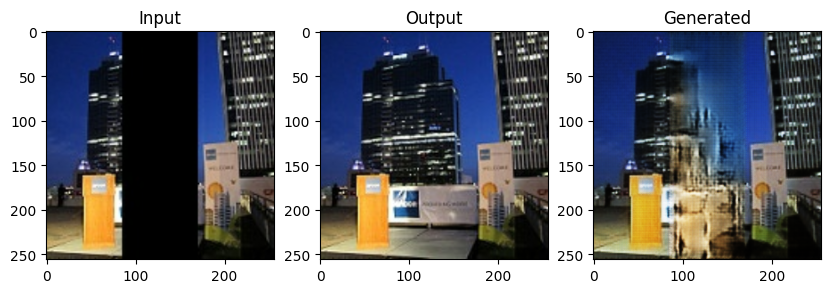

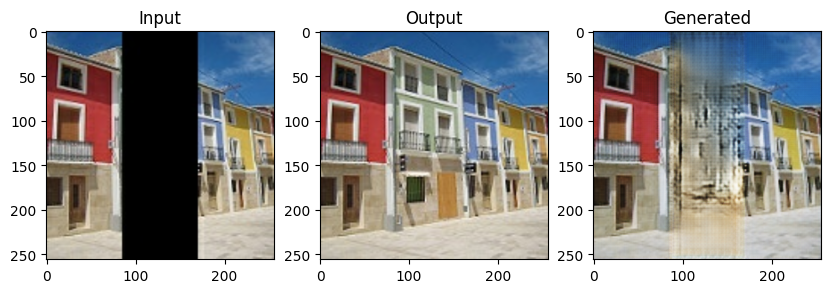

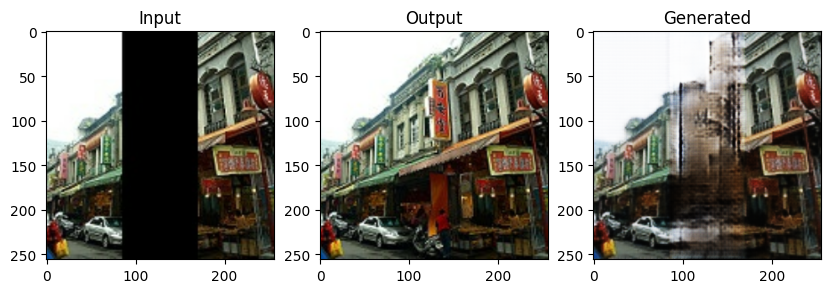

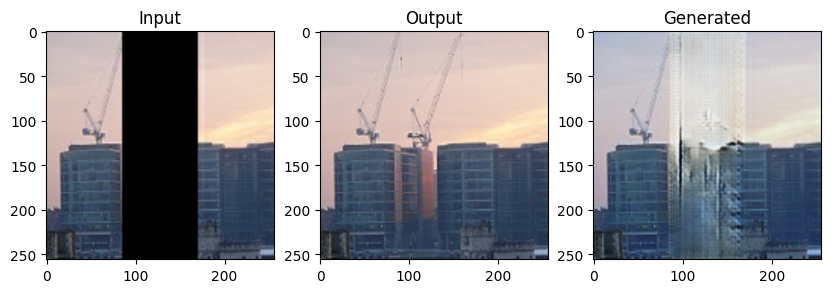

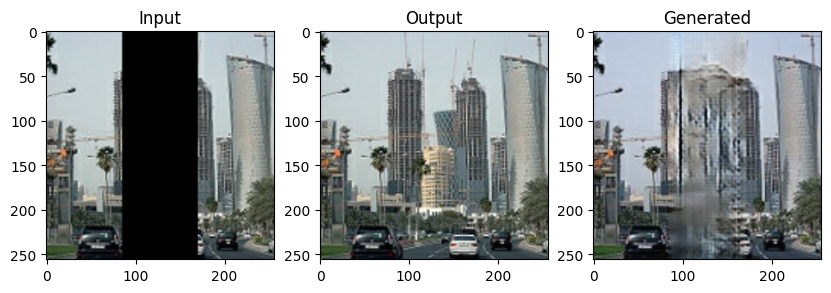

In [31]:
i = 0
while i < NUMBER_OF_TEST_IMAGES:
    random_index = random.randint(0, len(test_images))
    test_input_image, test_output_image = test_images[random_index]
    display_images(generator.model, test_input_image, test_output_image)
    i += 1